### Load Mujoco Engine

In [1]:
import mujoco
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("..")
from model.mujoco_parser import MuJoCoParserClass
from model.util import sample_xyzs,rpy2r,r2quat
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo version:[%s]"%(mujoco.__version__))

MuJoCo version:[2.3.4]


### Parse

In [2]:
xml_path = '../asset/ur5e/scene_ur5e_rg2_obj.xml'
env = MuJoCoParserClass(name='UR5e with RG2 gripper',rel_xml_path=xml_path,VERBOSE=True)
obj_names = [body_name for body_name in env.body_names
             if body_name is not None and (body_name.startswith("obj_"))]
n_obj = len(obj_names)
# Place objects in a row
xyzs = sample_xyzs(n_sample=n_obj,
                   x_range=[0.45,1.65],y_range=[-0.38,0.38],z_range=[0.81,0.81],min_dist=0.2)
colors = np.array([plt.cm.gist_rainbow(x) for x in np.linspace(0,1,n_obj)])
for obj_idx,obj_name in enumerate(obj_names):
    jntadr = env.model.body(obj_name).jntadr[0]
    env.model.joint(jntadr).qpos0[:3] = xyzs[obj_idx,:]
    geomadr = env.model.body(obj_name).geomadr[0]
    env.model.geom(geomadr).rgba = colors[obj_idx] # color

# Move tables and robot base
env.model.body('base_table').pos = np.array([0,0,0])
env.model.body('front_object_table').pos = np.array([1.05,0,0])
env.model.body('side_object_table').pos = np.array([0,-0.85,0])
env.model.body('base').pos = np.array([0,0,0.8])
print ("Ready.")

dt:[0.0020] HZ:[500]
n_body:[52]
geom_names:['floor', None, None, None, None, None, 'ur_shoulder_link_collision', None, None, None, None, 'ur_upper_arm_link_1_collision', 'ur_upper_arm_link_2_collision', None, None, None, None, 'ur_forearm_link_1_collision', 'ur_forearm_link_2_collision', None, None, None, 'ur_wrist_1_link_collision', None, None, None, 'ur_wrist_2_link_1_collision', 'ur_wrist_2_link_2_collision', None, 'ur_wrist_3_link_collision', 'ur_tcp_link_collision', 'camera_mount_collision', 'camera_mounted_gear_collision', 'ur_rg2_gripper_base_link_collision', 'camera_center_collision', 'ur_rg2_gripper_finger1_finger_link_collision', 'ur_rg2_gripper_finger1_inner_knuckle_link_collision', 'ur_rg2_gripper_finger1_finger_tip_link_collision', 'ur_rg2_gripper_finger2_finger_link_collision', 'ur_rg2_gripper_finger2_inner_knuckle_link_collision', 'ur_rg2_gripper_finger2_finger_tip_link_collision', 'front_object_table', 'side_object_table', 'base_table', 'obj_cylinder_01', 'obj_cylinder

### Get gripper joint indexes

In [3]:
gripper_joint_idxs = []

for gripper_idx in env.rev_joint_idxs:
    if gripper_idx not in env.idxs_forward:
        gripper_joint_idxs.append(gripper_idx)
print(f"Gripper joint idxs: {gripper_joint_idxs}")

Gripper joint idxs: [6, 7, 8, 9, 10, 11]


In [4]:
q_init = [-1.570521656666891, -2.311883111993307, 2.1441715399371546, 1.73920385419812, 0.7853929996490479, -1.5711215178119105]
q_close_grasp = [-0.03, -0.0273, -0.03, 0.03, 0.0273, 0.03]

### Solve `General` form of Inverse Kinematics on `Mujoco Engine`
#### Doesn't consider the `collisions`

In [5]:
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=0.0,distance=3.5,elevation=-60,lookat=[0.4,0.05,0.36],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=True,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=True,jointlength=0.5,jointwidth=0.1,jointrgba=[0.2,0.6,0.8,0.6])
env.reset()

R_trgt = rpy2r(np.radians([-180,0,90]))

q_ik = env.solve_ik(
    body_name='tcp_link',p_trgt=np.array([1.0, -0.2, 1.10]),R_trgt=R_trgt,
    IK_P=True,IK_R=True, q_init=np.array(q_init),idxs_forward=env.idxs_forward, idxs_jacobian=env.idxs_jacobian,
    RESET=False,DO_RENDER=True,render_every=1,th=1*np.pi/180.0,err_th=1e-3,w_weight=0.3)

# Close viewer
env.close_viewer()
print ("Done.")

print(q_ik)

Done.
[-0.45 -0.59  0.6  -0.01  1.13  0.  ]


In [6]:
# interpolation btw joint_value and q_ik
q_traj_list = []
q_traj = np.linspace(np.array(q_init), q_ik, 100)
for q in q_traj:
    env.forward(q, env.idxs_forward)
    p_curr = env.get_p_body('tcp_link')
    q_traj_list.append(p_curr)

Pressed ESC
Quitting.


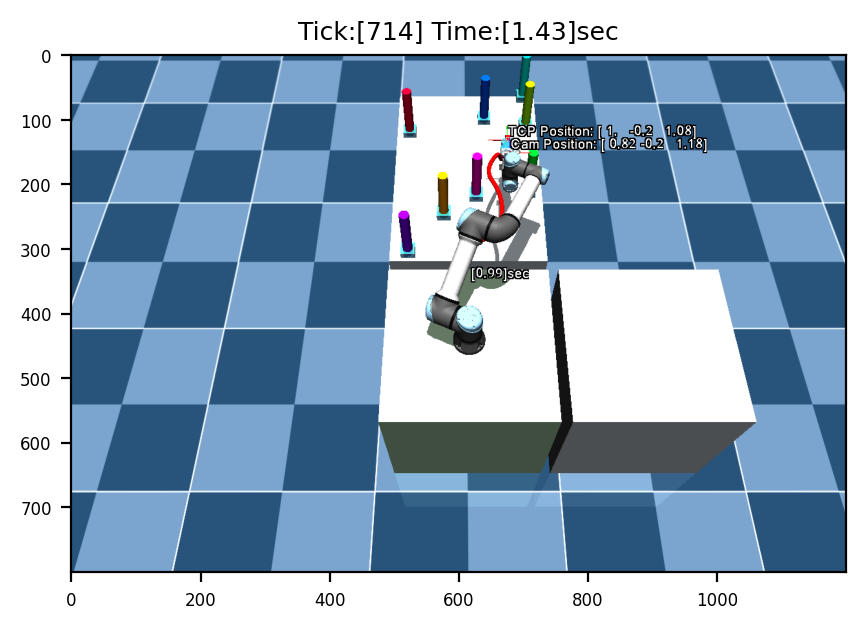

Done.


In [7]:
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=0.0,distance=3.5,elevation=-60,lookat=[0.4,0.05,0.36],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=True,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=True,jointlength=0.5,jointwidth=0.1,jointrgba=[0.2,0.6,0.8,0.6])
env.reset()
env.forward(q=q_init, joint_idxs=env.idxs_forward)

q_traj_list = []
tick = 0
while (env.get_sim_time() < 100.0) and env.is_viewer_alive():
    tick = tick + 1
    env.step(ctrl=q_ik, ctrl_idxs=env.idxs_forward)
    # Render
    p_tcp,R_tcp = env.get_pR_body(body_name='tcp_link')
    p_cam,R_cam = env.get_pR_body(body_name='camera_center')
    p_base,R_base = env.get_pR_body(body_name='base')
    # env.plot_T(p=np.zeros(3),R=np.eye(3,3),PLOT_AXIS=True,axis_len=1.0,axis_width=0.01)
    env.plot_T(p=p_tcp,R=R_tcp,PLOT_AXIS=True,axis_len=0.1,axis_width=0.0025,
               label=f'TCP Position: {p_tcp}')
    env.plot_T(p=p_cam,R=R_cam,PLOT_AXIS=True,axis_len=0.1,axis_width=0.0025,
               label=f'Cam Position: {p_cam}')
    # env.plot_T(p=p_base,R=R_base,PLOT_AXIS=True,axis_len=1.0,axis_width=0.01)
    env.plot_T(p=p_base+np.array([0,0,0.5]),R=np.eye(3,3),
                PLOT_AXIS=False,label='[%.2f]sec'%(env.get_sim_time()))
    
    q_traj_list.append(p_tcp)
    for p_eef in q_traj_list: env.plot_sphere(p=p_eef, r=0.01, rgba=[1,0,0,1])

    env.render()
    if env.loop_every(HZ=1) or (tick == 1):
        scene_img = env.grab_image()
# Plot an image
plt.figure(figsize=(5,4)); plt.imshow(scene_img)
plt.title("Tick:[%d] Time:[%.2f]sec"%(env.tick,env.get_sim_time()),fontsize=9)
plt.show()
# Close viewer
env.close_viewer()
print ("Done.")

## `Quintic` trajectory planning

Time: 0.00s
Joint 1: Position: -1.57, Velocity: 0.00, Acceleration: 0.00
Joint 2: Position: -2.31, Velocity: 0.00, Acceleration: 0.00
Joint 3: Position: 2.14, Velocity: 0.00, Acceleration: 0.00
Joint 4: Position: 1.74, Velocity: 0.00, Acceleration: 0.00
Joint 5: Position: 0.79, Velocity: 0.00, Acceleration: 0.00
Joint 6: Position: -1.57, Velocity: 0.00, Acceleration: 0.00
Time: 0.00s
Joint 1: Position: -1.57, Velocity: 0.00, Acceleration: 0.00
Joint 2: Position: -2.31, Velocity: 0.00, Acceleration: 0.01
Joint 3: Position: 2.14, Velocity: -0.00, Acceleration: -0.01
Joint 4: Position: 1.74, Velocity: -0.00, Acceleration: -0.01
Joint 5: Position: 0.79, Velocity: 0.00, Acceleration: 0.00
Joint 6: Position: -1.57, Velocity: 0.00, Acceleration: 0.01
Time: 0.00s
Joint 1: Position: -1.57, Velocity: 0.00, Acceleration: 0.01
Joint 2: Position: -2.31, Velocity: 0.00, Acceleration: 0.02
Joint 3: Position: 2.14, Velocity: -0.00, Acceleration: -0.01
Joint 4: Position: 1.74, Velocity: -0.00, Accelera

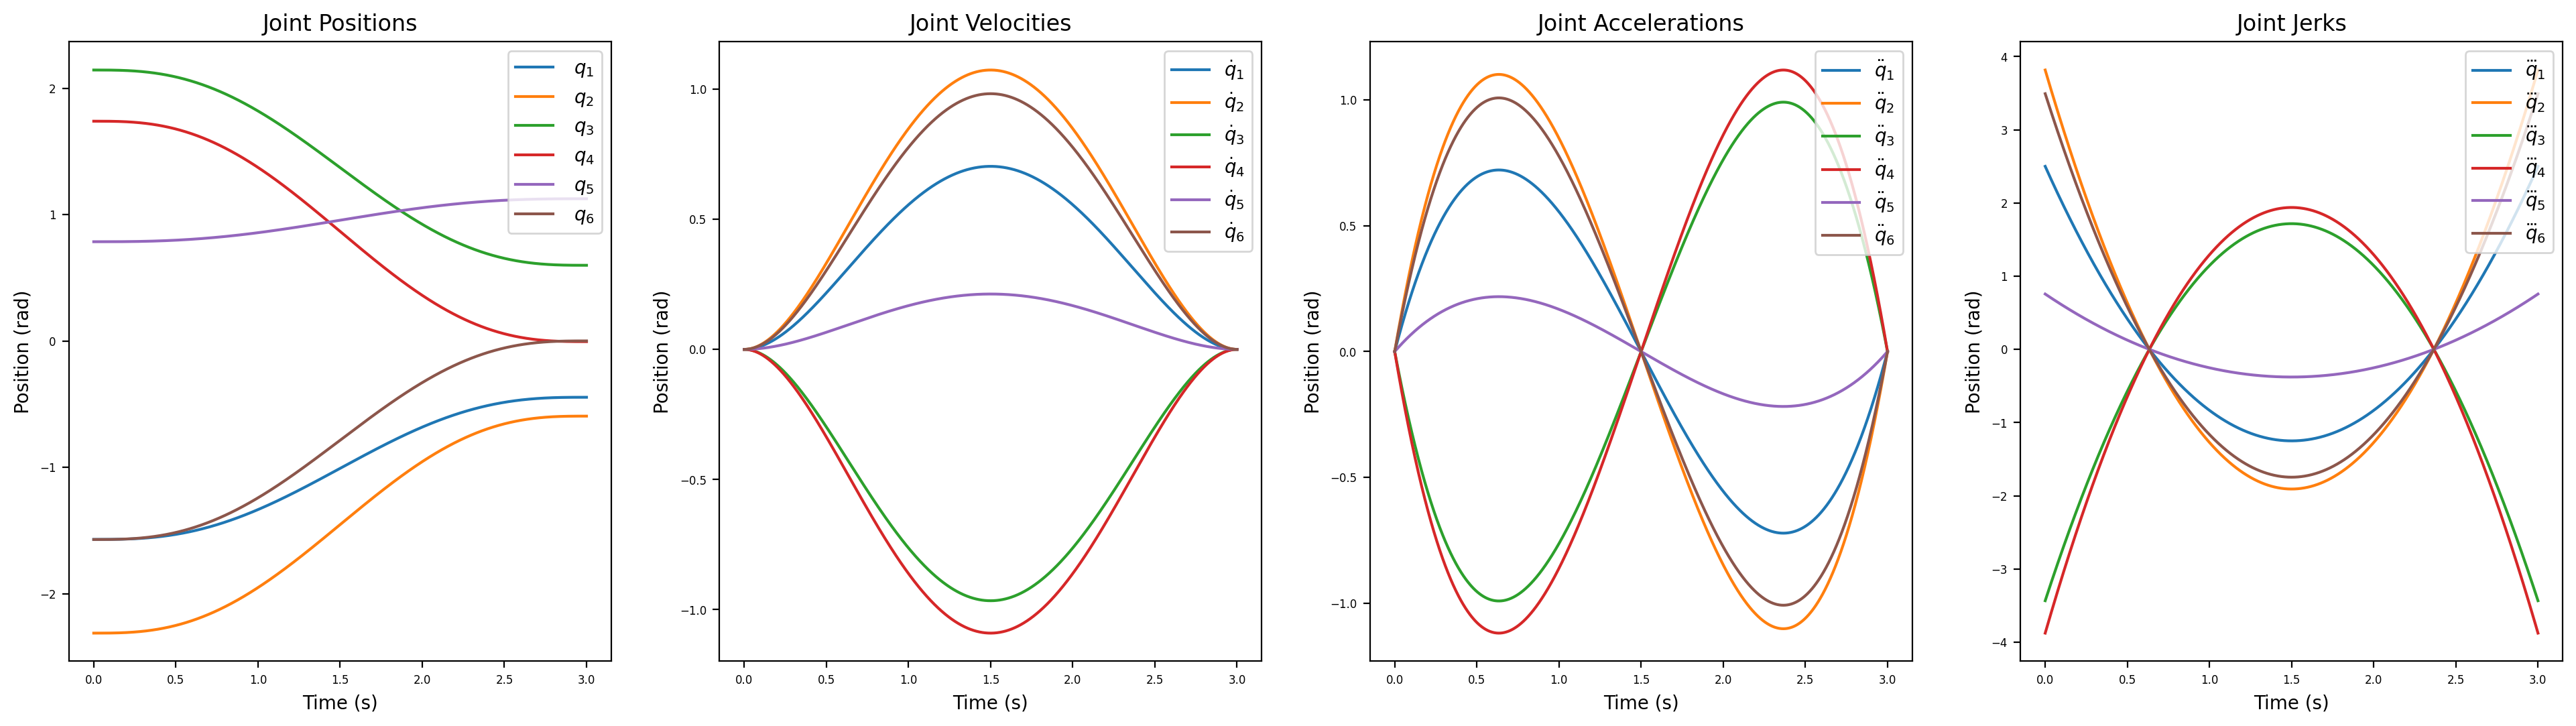

In [65]:
import numpy as np

def quintic_trajectory(start_pos, start_vel, start_acc, end_pos, end_vel, end_acc, duration, num_points, max_velocity, max_acceleration):
    # Compute time intervals
    t = np.linspace(0, duration, num_points)

    # Compute polynomial coefficients for each joint
    joint_coeffs = []
    for i in range(6):
        # Solve for polynomial coefficients: Ax = b (A=quintic trajectory, x=coeff vec, b=constraints)
        # A: 6x6 matrix, x: 6x1 vector, b: 6x1 vector
        A = np.array([[0, 0, 0, 0, 0, 1],
                      [0, 0, 0, 0, 1, 0],
                      [0, 0, 0, 2, 0, 0],
                      [duration**5, duration**4, duration**3, duration**2, duration, 1],
                      [5*duration**4, 4*duration**3, 3*duration**2, 2*duration, 1, 0],
                      [20*duration**3, 12*duration**2, 6*duration, 2, 0, 0]])

        b = np.array([start_pos[i], start_vel[i], start_acc[i], end_pos[i], end_vel[i], end_acc[i]])

        # Solve for polynomial coefficients
        x = np.linalg.solve(A, b)
        joint_coeffs.append(x)

    # Generate trajectory points for each joint
    positions = np.zeros((num_points, 6))
    velocities = np.zeros((num_points, 6))
    accelerations = np.zeros((num_points, 6))
    jerks = np.zeros((num_points, 6))

    for i in range(num_points):
        for j in range(6):
            positions[i, j] = np.polyval(joint_coeffs[j], t[i])   # Compute 0th derivative
            velocities[i, j] = np.polyval(np.polyder(joint_coeffs[j]), t[i])  # Compute 1st derivative
            accelerations[i, j] = np.polyval(np.polyder(np.polyder(joint_coeffs[j])), t[i])   # Compute 2nd derivative
            jerks[i, j] = np.polyval(np.polyder(np.polyder(np.polyder(joint_coeffs[j]))), t[i])   # Compute 3rd derivative

    # Apply velocity and acceleration constraints
    velocities = np.clip(velocities, -max_velocity, max_velocity)
    accelerations = np.clip(accelerations, -max_acceleration, max_acceleration)

    return positions, velocities, accelerations, jerks

# Define the conditions of the trajectory
start_pos = q_init
start_vel = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
start_acc = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
end_pos = q_ik
end_vel = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
end_acc = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
duration = 3.0  # Time to complete trajectory.
num_points = int(duration / env.dt)
max_velocity = 2.0
max_acceleration = 2.0

positions, velocities, accelerations, jerks = quintic_trajectory(start_pos, start_vel, start_acc, end_pos, end_vel, end_acc, duration, num_points, max_velocity, max_acceleration)

# Print the generated trajectory points for each joint
for i in range(num_points):
    print(f"Time: {i * duration / num_points:.2f}s")
    for j in range(6):
        print(f"Joint {j+1}: Position: {positions[i, j]:.2f}, Velocity: {velocities[i, j]:.2f}, Acceleration: {accelerations[i, j]:.2f}")

time_step = np.linspace(0, duration, num_points)
plt.figure(figsize=(24, 6))
plt.subplot(1, 4, 1)
for i in range(6):
    plt.plot(time_step, positions[:, i], label=rf"$\ q_{i+1}$")
plt.xlabel("Time (s)")
plt.ylabel("Position (rad)")
plt.title("Joint Positions")
plt.legend(loc='upper right')
# plt.show()

plt.subplot(1, 4, 2)
for i in range(6):
    plt.plot(time_step, velocities[:, i], label=rf"$\dot q_{i+1}$")
plt.xlabel("Time (s)")
plt.ylabel("Position (rad)")
plt.title("Joint Velocities")
plt.legend(loc='upper right')
# plt.show()

plt.subplot(1, 4, 3)
for i in range(6):
    plt.plot(time_step, accelerations[:, i], label=rf"$\ddot q_{i+1}$")

plt.xlabel("Time (s)")
plt.ylabel("Position (rad)")
plt.title("Joint Accelerations")
plt.legend(loc='upper right')
# plt.show()

plt.subplot(1, 4, 4)
for i in range(6):
    plt.plot(time_step, jerks[:, i], label=rf"$\dddot q_{i+1}$")

plt.xlabel("Time (s)")
plt.ylabel("Position (rad)")
plt.title("Joint Jerks")
plt.legend(loc='upper right')
plt.show()

In [9]:
env.reset()

p_eef_list = []
for q in positions:
    env.forward(q=q, joint_idxs=env.idxs_forward)
    p_eef_list.append(env.get_p_body('tcp_link'))

p_eef_list_np = np.array(p_eef_list)[::30]  # downsample to visualize with markers.

Pressed ESC
Quitting.


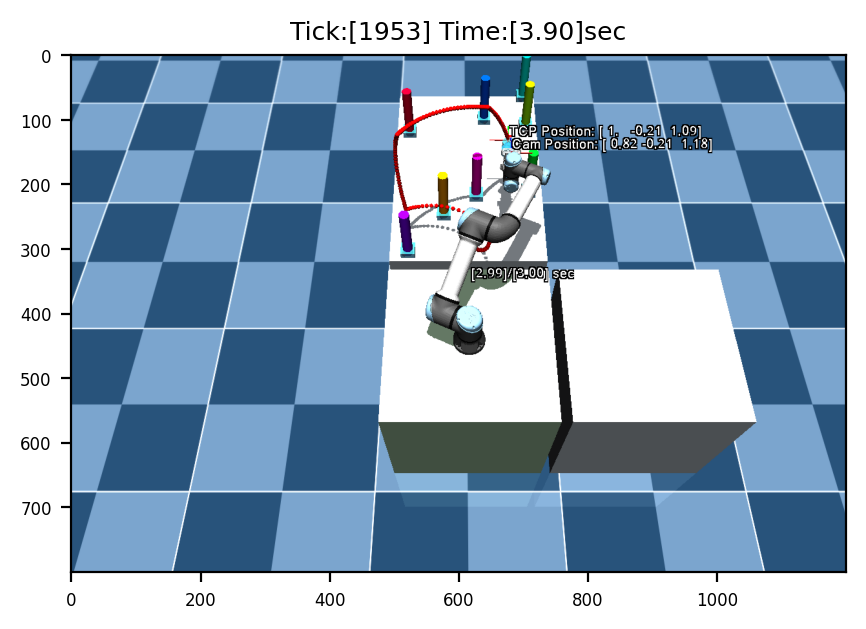

Done.


In [34]:
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=0.0,distance=3.5,elevation=-60,lookat=[0.4,0.05,0.36],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=True,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=True,jointlength=0.5,jointwidth=0.1,jointrgba=[0.2,0.6,0.8,0.6])
env.reset()
env.forward(q=q_init, joint_idxs=env.idxs_forward)

p_eef_list_quintic = []

tick = 0
while (env.get_sim_time() < 100.0) and env.is_viewer_alive():
    tick = tick + 1
    if tick >= len(positions):
        env.step(ctrl=positions[-1,:], ctrl_idxs=env.idxs_forward)
    else:    
        env.step(ctrl=positions[tick,:], ctrl_idxs=env.idxs_forward)
        
    # Render
    p_tcp,R_tcp = env.get_pR_body(body_name='tcp_link')
    p_eef_list_quintic.append(env.get_p_body('tcp_link'))

    p_cam,R_cam = env.get_pR_body(body_name='camera_center')
    p_base,R_base = env.get_pR_body(body_name='base')
    # env.plot_T(p=np.zeros(3),R=np.eye(3,3),PLOT_AXIS=True,axis_len=1.0,axis_width=0.01)
    env.plot_T(p=p_tcp,R=R_tcp,PLOT_AXIS=True,axis_len=0.1,axis_width=0.0025,
               label=f'TCP Position: {p_tcp}')
    env.plot_T(p=p_cam,R=R_cam,PLOT_AXIS=True,axis_len=0.1,axis_width=0.0025,
               label=f'Cam Position: {p_cam}')
    # env.plot_T(p=p_base,R=R_base,PLOT_AXIS=True,axis_len=1.0,axis_width=0.01)
    env.plot_T(p=p_base+np.array([0,0,0.5]),R=np.eye(3,3),
                PLOT_AXIS=False,label='[%.2f]/[%.2f] sec'%(env.get_sim_time(), duration))
    for p_eef in p_eef_list_np: 
        env.plot_sphere(p=p_eef, r=0.01, rgba=[1,0,0,1])
    env.render()
    if env.loop_every(HZ=1) or (tick == 1):
        scene_img = env.grab_image()
# Plot an image
plt.figure(figsize=(5,4)); plt.imshow(scene_img)
plt.title("Tick:[%d] Time:[%.2f]sec"%(env.tick,env.get_sim_time()),fontsize=9)
plt.show()
# Close viewer
env.close_viewer()
print ("Done.")

### `Multiple waypoints` via quintic trajectory planning

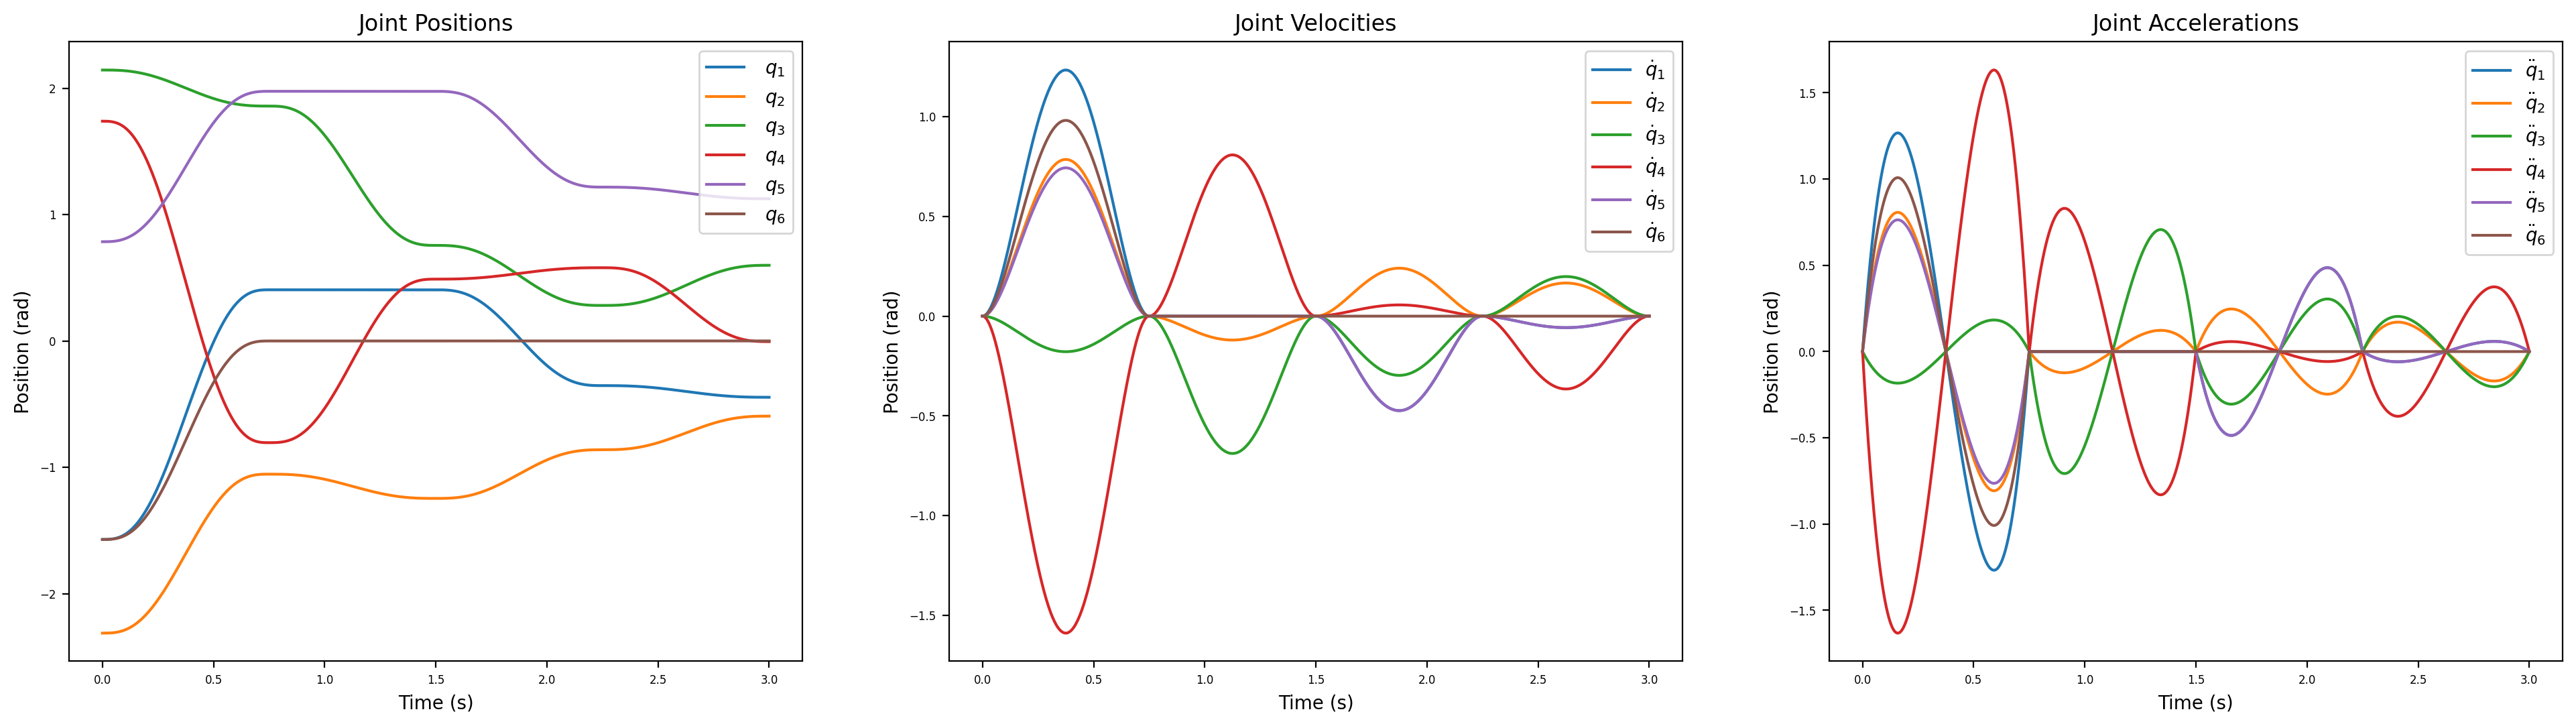

In [11]:
import numpy as np

def quintic_trajectory(start_pos, start_vel, start_acc, end_pos, end_vel, end_acc, duration, num_points, max_velocity, max_acceleration):
    # Compute time intervals
    t = np.linspace(0, duration, num_points)

    # Compute polynomial coefficients for each joint
    joint_coeffs = []
    for i in range(6):
        # Solve for polynomial coefficients: Ax = b (A=quintic trajectory, x=coeff vec, b=constraints)
        # A: 6x6 matrix, x: 6x1 vector, b: 6x1 vector
        A = np.array([[0, 0, 0, 0, 0, 1],
                      [0, 0, 0, 0, 1, 0],
                      [0, 0, 0, 2, 0, 0],
                      [duration**5, duration**4, duration**3, duration**2, duration, 1],
                      [5*duration**4, 4*duration**3, 3*duration**2, 2*duration, 1, 0],
                      [20*duration**3, 12*duration**2, 6*duration, 2, 0, 0]])

        b = np.array([start_pos[i], start_vel[i], start_acc[i], end_pos[i], end_vel[i], end_acc[i]])

        # Solve for polynomial coefficients
        x = np.linalg.solve(A, b)
        joint_coeffs.append(x)

    # Generate trajectory points for each joint
    positions = np.zeros((num_points, 6))
    velocities = np.zeros((num_points, 6))
    accelerations = np.zeros((num_points, 6))
    jerks = np.zeros((num_points, 6))

    for i in range(num_points):
        for j in range(6):
            positions[i, j] = np.polyval(joint_coeffs[j], t[i])   # Compute 0th derivative
            velocities[i, j] = np.polyval(np.polyder(joint_coeffs[j]), t[i])  # Compute 1st derivative
            accelerations[i, j] = np.polyval(np.polyder(np.polyder(joint_coeffs[j])), t[i])   # Compute 2nd derivative
            jerks[i, j] = np.polyval(np.polyder(np.polyder(np.polyder(joint_coeffs[j]))), t[i])   # Compute 3rd derivative

    # Apply velocity and acceleration constraints
    velocities = np.clip(velocities, -max_velocity, max_velocity)
    accelerations = np.clip(accelerations, -max_acceleration, max_acceleration)

    return positions, velocities, accelerations, jerks

# Define the conditions of the trajectory
start_vel = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
start_acc = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
end_vel = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
end_acc = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
duration = 3.0  # Time to complete trajectory.
num_points = int(duration / env.dt) # Number of points in trajectory
max_velocity = 2.0
max_acceleration = 2.0

# Define all waypoints
q_grasp = np.array([23.2, -60.39, 106.5, -46.11, 113.2, 0.]) * np.pi/180
q_liftup = np.array([23.2, -71.38, 43.34, 28.04, 113.2, -0.]) * np.pi/180
q_place = np.array([-20.24, -49.32, 16.11, 33.21, 69.76, 0.]) * np.pi/180
waypoints = [q_init, q_grasp, q_liftup, q_place, q_ik]

positions_list = []
velocities_list = []
accelerations_list = []
jerks_list = []

for i in range(len(waypoints)-1):
    start_pos = waypoints[i]
    end_pos = waypoints[i+1]

    positions, velocities, accelerations, jerks = quintic_trajectory(start_pos, start_vel, start_acc, end_pos, end_vel, end_acc, duration, num_points, max_velocity, max_acceleration)

    positions_list.append(positions)
    velocities_list.append(velocities)
    accelerations_list.append(accelerations)
    jerks_list.append(jerks)

# Concatenate all trajectories
positions = np.concatenate(positions_list)
velocities = np.concatenate(velocities_list)
accelerations = np.concatenate(accelerations_list)
jerks = np.concatenate(jerks_list)

time_step = np.linspace(0, duration, num_points * (len(waypoints)-1))
plt.figure(figsize=(24, 6))
plt.subplot(1, 3, 1)
for i in range(6):
    plt.plot(time_step, positions[:, i], label=rf"$\ q_{i+1}$")
plt.xlabel("Time (s)")
plt.ylabel("Position (rad)")
plt.title("Joint Positions")
plt.legend(loc='upper right')
# plt.show()

plt.subplot(1, 3, 2)
for i in range(6):
    plt.plot(time_step, velocities[:, i], label=rf"$\dot q_{i+1}$")
plt.xlabel("Time (s)")
plt.ylabel("Position (rad)")
plt.title("Joint Velocities")
plt.legend(loc='upper right')
# plt.show()

plt.subplot(1, 3, 3)
for i in range(6):
    plt.plot(time_step, accelerations[:, i], label=rf"$\ddot q_{i+1}$")

plt.xlabel("Time (s)")
plt.ylabel("Position (rad)")
plt.title("Joint Accelerations")
plt.legend(loc='upper right')
plt.show()


In [12]:
env.reset()

p_eef_list = []
for q in positions:
    env.forward(q=q, joint_idxs=env.idxs_forward)
    p_eef_list.append(env.get_p_body('tcp_link'))

p_eef_list_np = np.array(p_eef_list)[::30]  # downsample to visualize with markers.

Pressed ESC
Quitting.


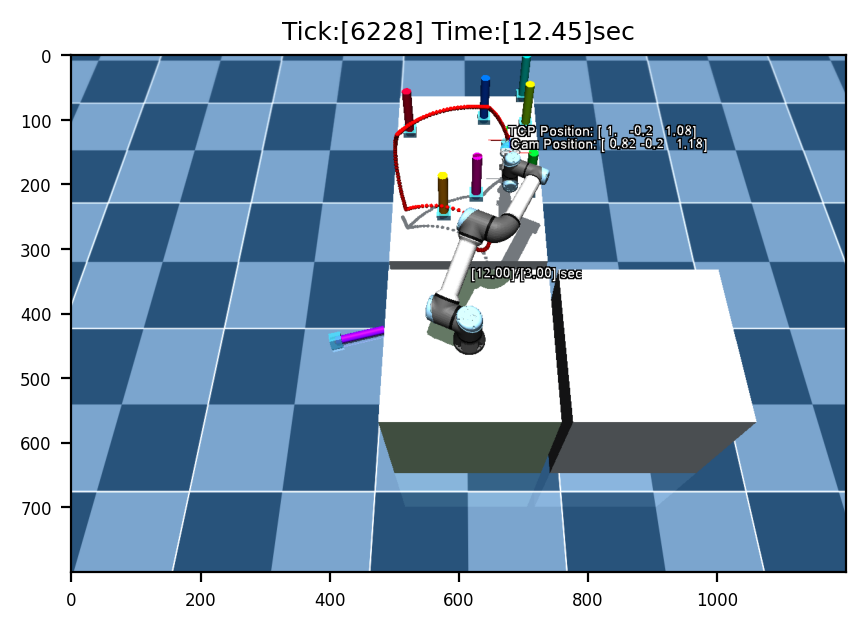

Done.


In [13]:
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=0.0,distance=3.5,elevation=-60,lookat=[0.4,0.05,0.36],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=True,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=True,jointlength=0.5,jointwidth=0.1,jointrgba=[0.2,0.6,0.8,0.6])
env.reset()
env.forward(q=q_init, joint_idxs=env.idxs_forward)

p_eef_list_quintic = []

tick = 0
while (env.get_sim_time() < 100.0) and env.is_viewer_alive():
    tick = tick + 1
    if tick >= len(positions):
        env.step(ctrl=positions[-1,:], ctrl_idxs=env.idxs_forward)
    else:    
        env.step(ctrl=positions[tick,:], ctrl_idxs=env.idxs_forward)
        
    # Render
    p_tcp,R_tcp = env.get_pR_body(body_name='tcp_link')
    p_eef_list_quintic.append(env.get_p_body('tcp_link'))

    p_cam,R_cam = env.get_pR_body(body_name='camera_center')
    p_base,R_base = env.get_pR_body(body_name='base')
    # env.plot_T(p=np.zeros(3),R=np.eye(3,3),PLOT_AXIS=True,axis_len=1.0,axis_width=0.01)
    env.plot_T(p=p_tcp,R=R_tcp,PLOT_AXIS=True,axis_len=0.1,axis_width=0.0025,
               label=f'TCP Position: {p_tcp}')
    env.plot_T(p=p_cam,R=R_cam,PLOT_AXIS=True,axis_len=0.1,axis_width=0.0025,
               label=f'Cam Position: {p_cam}')
    # env.plot_T(p=p_base,R=R_base,PLOT_AXIS=True,axis_len=1.0,axis_width=0.01)
    env.plot_T(p=p_base+np.array([0,0,0.5]),R=np.eye(3,3),
                PLOT_AXIS=False,label='[%.2f]/[%.2f] sec'%(env.get_sim_time(), duration))
    for p_eef in p_eef_list_np: 
        env.plot_sphere(p=p_eef, r=0.01, rgba=[1,0,0,1])
    env.render()
    if env.loop_every(HZ=1) or (tick == 1):
        scene_img = env.grab_image()
# Plot an image
plt.figure(figsize=(5,4)); plt.imshow(scene_img)
plt.title("Tick:[%d] Time:[%.2f]sec"%(env.tick,env.get_sim_time()),fontsize=9)
plt.show()
# Close viewer
env.close_viewer()
print ("Done.")

### Minimum `Jerk` trajectory planning

#### reference about this link: `https://mika-s.github.io/python/control-theory/trajectory-generation/2017/12/06/trajectory-generation-with-a-minimum-jerk-trajectory.html`

Minimum Jerk Trajectory Generator


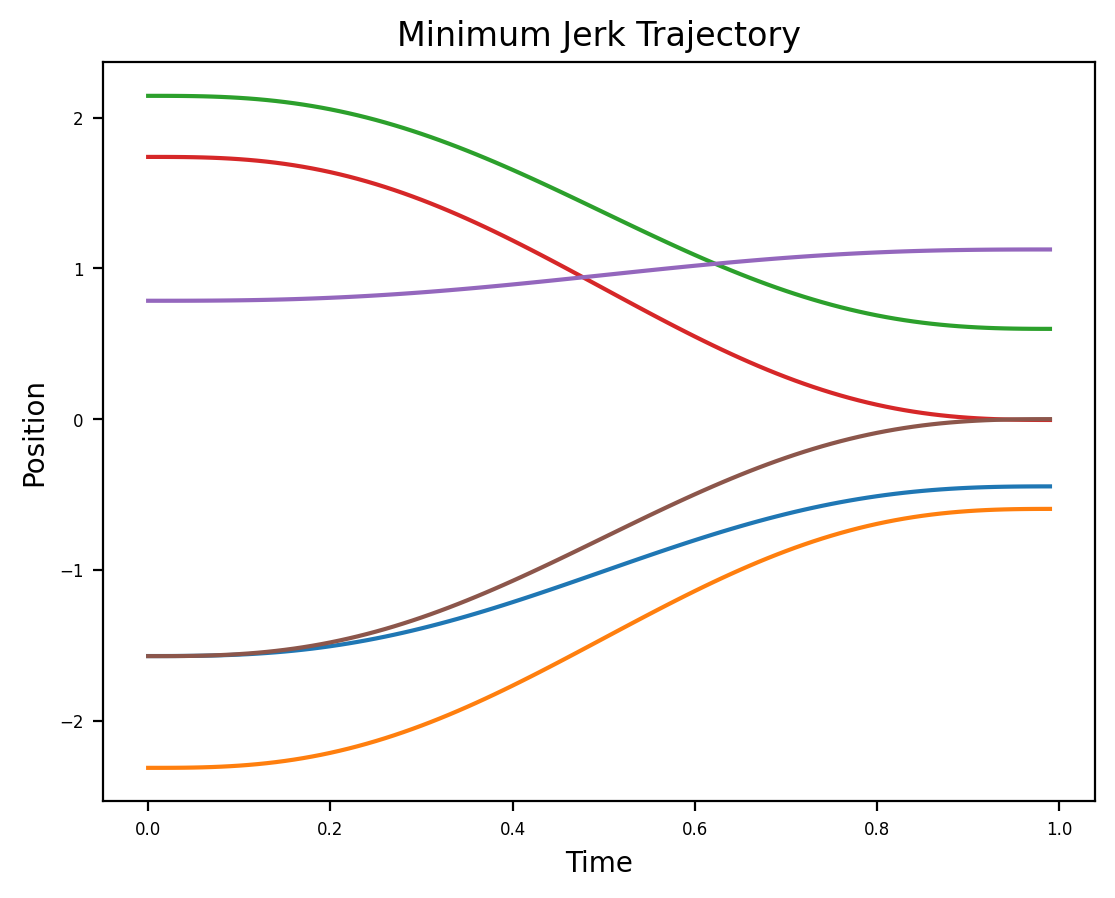

In [60]:
import numpy as np 
import matplotlib.pyplot as plt

def minimum_jerk_trajectory(init_pos, target_pos, total_time=0.5, dt=0.01):
    q_init = init_pos
    q_final = target_pos
    duration = total_time
    list_t = []
    list_q = []
    t = 0
    while t < duration:
        q = q_init + (q_final-q_init) * (10*(t/duration)**3 - 15*(t/duration)**4 + 6*(t/duration)**5)
        list_t.append(t)
        list_q.append(q)
        t += dt
    return np.array(list_t), np.array(list_q)

print("Minimum Jerk Trajectory Generator")
# This is initial position of servo motor
init_pos = q_init
# This is target position of servo motor
target_pos = q_ik
# We want to move all joint from initial to target position in 1 seconds
t_jerk, q_traj_jerk = minimum_jerk_trajectory(init_pos, target_pos, total_time=1)
# Show the result
fig, ax = plt.subplots()
ax.plot(t_jerk, q_traj_jerk)
ax.set_title("Minimum Jerk Trajectory")
ax.set_xlabel("Time")
ax.set_ylabel("Position")
plt.show()


Pressed ESC
Quitting.


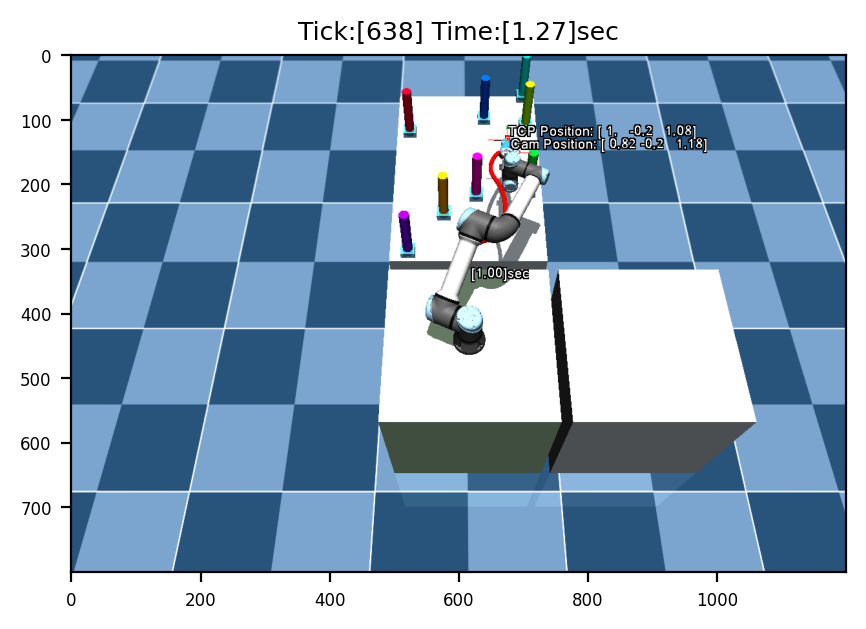

Done.


In [61]:
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=0.0,distance=3.5,elevation=-60,lookat=[0.4,0.05,0.36],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=True,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=True,jointlength=0.5,jointwidth=0.1,jointrgba=[0.2,0.6,0.8,0.6])
env.reset()
env.forward(q=[-1.570521656666891, -2.311883111993307, 2.1441715399371546, 1.73920385419812, 0.7853929996490479, -1.5711215178119105], joint_idxs=env.idxs_forward)

p_eef_list_min_jerk = []


tick = 0
while (env.get_sim_time() < 100.0) and env.is_viewer_alive():
    tick = tick + 1
    if tick >= q_traj_jerk.shape[0]:
        env.step(ctrl=q_traj_jerk[-1,:], ctrl_idxs=env.idxs_forward)
    else:    
        env.step(ctrl=q_traj_jerk[tick,:], ctrl_idxs=env.idxs_forward)
        
    # Render
    p_tcp,R_tcp = env.get_pR_body(body_name='tcp_link')
    p_eef_list_min_jerk.append(p_tcp)
    p_cam,R_cam = env.get_pR_body(body_name='camera_center')
    p_base,R_base = env.get_pR_body(body_name='base')
    # env.plot_T(p=np.zeros(3),R=np.eye(3,3),PLOT_AXIS=True,axis_len=1.0,axis_width=0.01)
    env.plot_T(p=p_tcp,R=R_tcp,PLOT_AXIS=True,axis_len=0.1,axis_width=0.0025,
               label=f'TCP Position: {p_tcp}')
    env.plot_T(p=p_cam,R=R_cam,PLOT_AXIS=True,axis_len=0.1,axis_width=0.0025,
               label=f'Cam Position: {p_cam}')
    # env.plot_T(p=p_base,R=R_base,PLOT_AXIS=True,axis_len=1.0,axis_width=0.01)
    env.plot_T(p=p_base+np.array([0,0,0.5]),R=np.eye(3,3),
                PLOT_AXIS=False,label='[%.2f]sec'%(env.get_sim_time()))
    for p_eef in np.array(p_eef_list_min_jerk): env.plot_sphere(p=p_eef, r=0.01, rgba=[1,0,0,1])

    env.render()
    if env.loop_every(HZ=1) or (tick == 1):
        scene_img = env.grab_image()
# Plot an image
plt.figure(figsize=(5,4)); plt.imshow(scene_img)
plt.title("Tick:[%d] Time:[%.2f]sec"%(env.tick,env.get_sim_time()),fontsize=9)
plt.show()
# Close viewer
env.close_viewer()
print ("Done.")

In [63]:
from model.util import get_interp_const_vel_traj

times,q_traj = get_interp_const_vel_traj(
    np.vstack((q_init,q_ik)),vel=np.radians(36.5),HZ=env.HZ)
print ("Joint trajectory ready. duration:[%.2f]sec"%(times[-1]))

Joint trajectory ready. duration:[2.74]sec


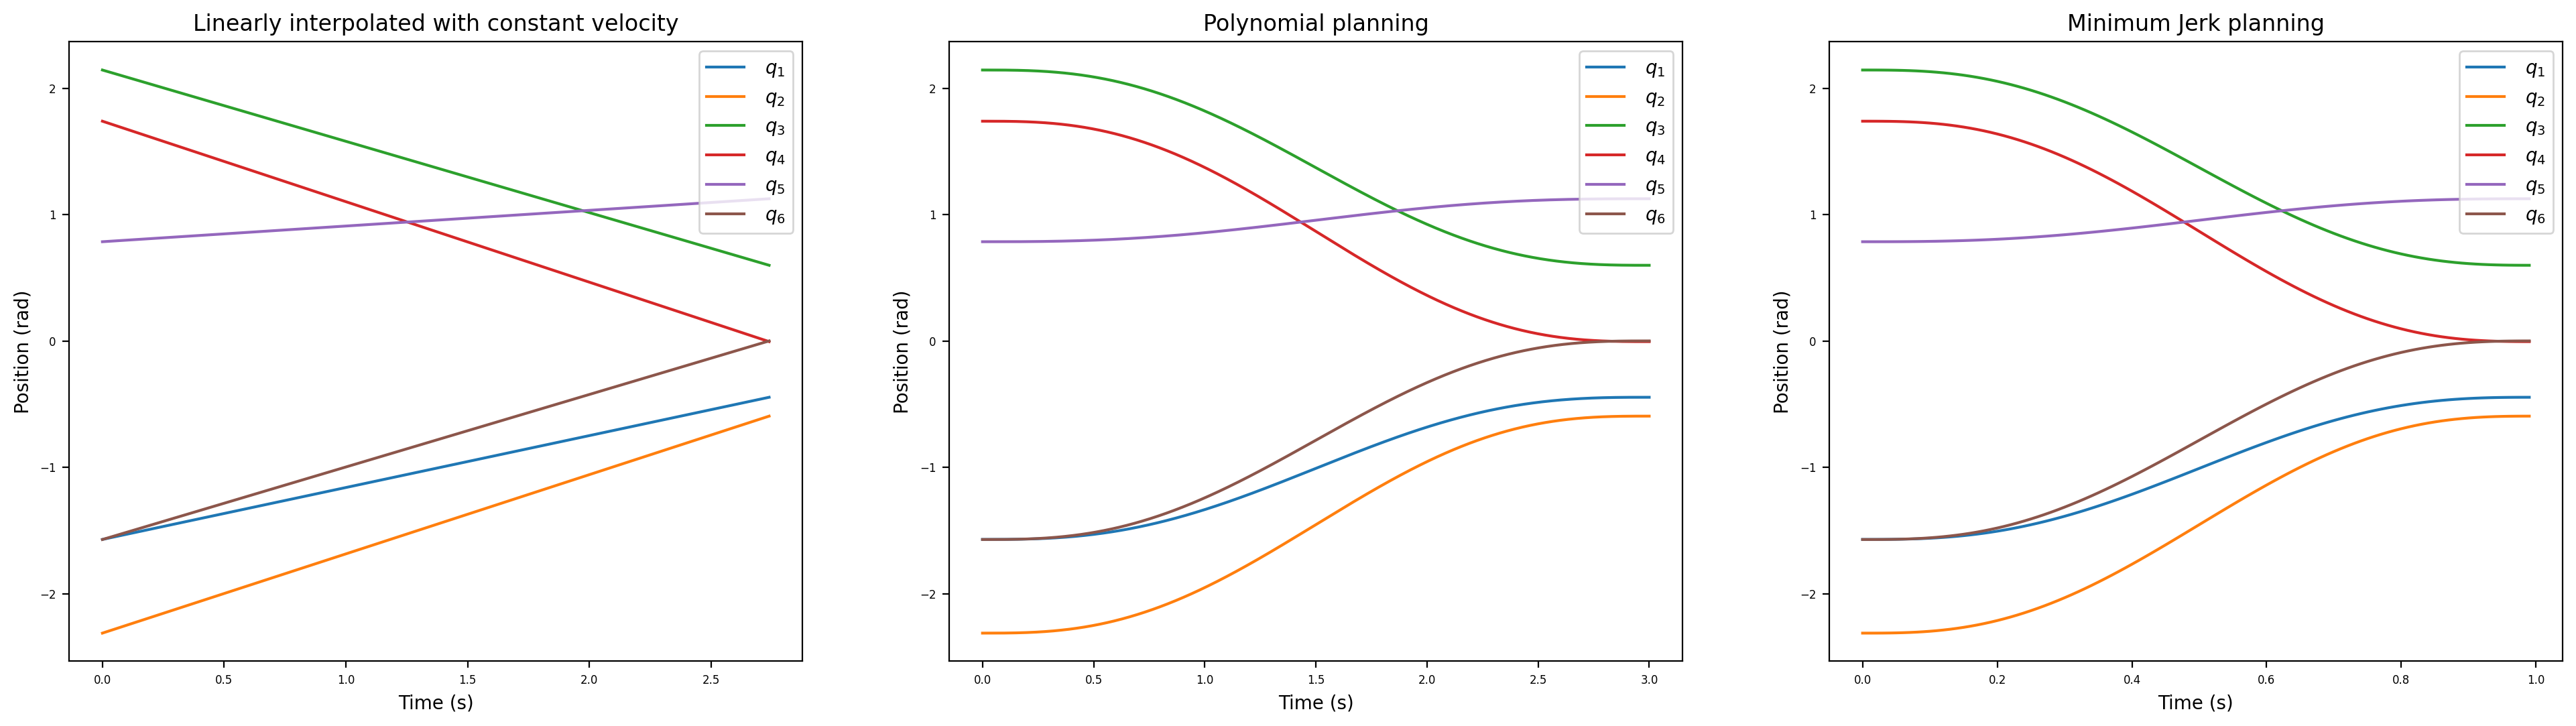

In [67]:
time_step = np.linspace(0, duration, num_points)
plt.figure(figsize=(24, 6))
plt.subplot(1, 3, 1)
for i in range(6):
    plt.plot(times, q_traj[:, i], label=rf"$\ q_{i+1}$")
plt.xlabel("Time (s)")
plt.ylabel("Position (rad)")
plt.title("Linearly interpolated with constant velocity")
plt.legend(loc='upper right')

plt.subplot(1, 3, 2)
for i in range(6):
    plt.plot(time_step, positions[:, i], label=rf"$\ q_{i+1}$")
plt.xlabel("Time (s)")
plt.ylabel("Position (rad)")
plt.title("Polynomial planning")
plt.legend(loc='upper right')

plt.subplot(1, 3, 3)
for i in range(6):
    plt.plot(t_jerk, q_traj_jerk[:, i], label=rf"$\ q_{i+1}$")
plt.xlabel("Time (s)")
plt.ylabel("Position (rad)")
plt.title("Minimum Jerk planning")
plt.legend(loc='upper right')

plt.show()

Pressed ESC
Quitting.


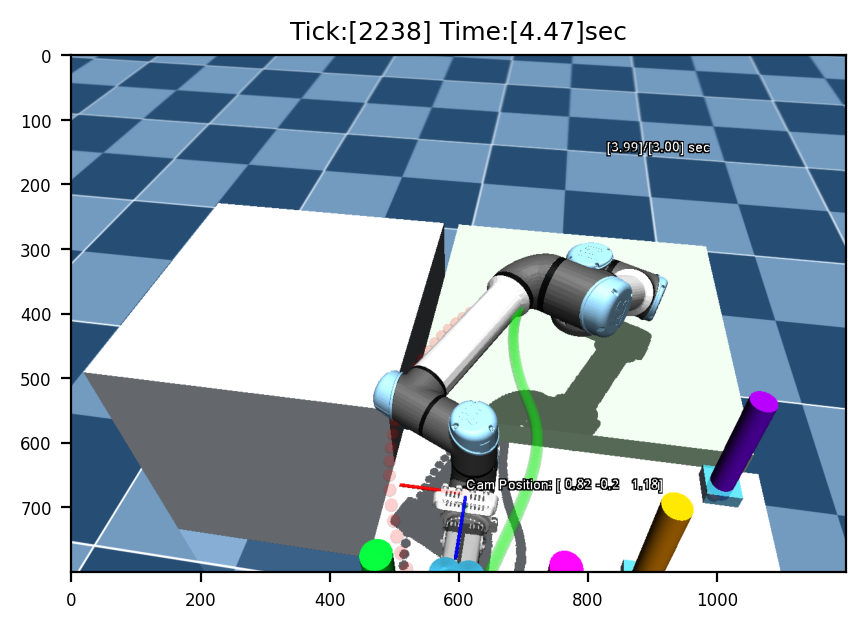

Done.


In [70]:
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=0.0,distance=3.5,elevation=-60,lookat=[0.4,0.05,0.36],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=True,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=True,jointlength=0.5,jointwidth=0.1,jointrgba=[0.2,0.6,0.8,0.6])
env.reset()
env.forward(q=q_init, joint_idxs=env.idxs_forward)

p_eef_list_intrp = []
# p_eef_list_quintic = []
p_eef_list_quintic = np.array(p_eef_list_quintic)[::30]  # downsample to visualize with markers.

tick = 0
while (env.get_sim_time() < 100.0) and env.is_viewer_alive():
    tick = tick + 1
    if tick >= len(q_traj):
        env.step(ctrl=q_traj[-1,:], ctrl_idxs=env.idxs_forward)
    else:    
        env.step(ctrl=q_traj[tick,:], ctrl_idxs=env.idxs_forward)
        
    # Render
    p_tcp,R_tcp = env.get_pR_body(body_name='tcp_link')
    if tick % 30 == 0:
        p_eef_list_intrp.append(env.get_p_body('tcp_link'))
        # p_eef_list_quintic.append(env.get_p_body('tcp_link'))
    p_cam,R_cam = env.get_pR_body(body_name='camera_center')
    p_base,R_base = env.get_pR_body(body_name='base')

    # env.plot_T(p=np.zeros(3),R=np.eye(3,3),PLOT_AXIS=True,axis_len=1.0,axis_width=0.01)
    env.plot_T(p=p_tcp,R=R_tcp,PLOT_AXIS=True,axis_len=0.1,axis_width=0.0025,
               label=f'TCP Position: {p_tcp}')
    env.plot_T(p=p_cam,R=R_cam,PLOT_AXIS=True,axis_len=0.1,axis_width=0.0025,
               label=f'Cam Position: {p_cam}')
    # env.plot_T(p=p_base,R=R_base,PLOT_AXIS=True,axis_len=1.0,axis_width=0.01)
    env.plot_T(p=p_base+np.array([0,0,0.5]),R=np.eye(3,3),
                PLOT_AXIS=False,label='[%.2f]/[%.2f] sec'%(env.get_sim_time(), duration))
    
    for p_eef in p_eef_list_quintic: 
        env.plot_sphere(p=p_eef, r=0.01, rgba=[0,0,1,0.1])

    for p_eef in p_eef_list_intrp: 
        env.plot_sphere(p=p_eef, r=0.01, rgba=[1,0,0,0.1])

    for p_eef in np.array(p_eef_list_min_jerk): 
        env.plot_sphere(p=p_eef, r=0.01, rgba=[0,1,0,0.05])

    env.render()
    if env.loop_every(HZ=1) or (tick == 1):
        scene_img = env.grab_image()
# Plot an image
plt.figure(figsize=(5,4)); plt.imshow(scene_img)
plt.title("Tick:[%d] Time:[%.2f]sec"%(env.tick,env.get_sim_time()),fontsize=9)
plt.show()
# Close viewer
env.close_viewer()
print ("Done.")

### `Linear movement` trajectory planning: Linear interpolation

In [71]:
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=0.0,distance=3.5,elevation=-60,lookat=[0.4,0.05,0.36],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=True,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=True,jointlength=0.5,jointwidth=0.1,jointrgba=[0.2,0.6,0.8,0.6])
env.reset()

R_trgt = rpy2r(np.radians([-180,0,90]))

q_square_1 = env.solve_ik(
    body_name='tcp_link',p_trgt=np.array([0.5, 0.5, 1.20]),R_trgt=R_trgt,
    IK_P=True,IK_R=True, q_init=np.array(q_init),idxs_forward=env.idxs_forward, idxs_jacobian=env.idxs_jacobian,
    RESET=False,DO_RENDER=True,render_every=1,th=1*np.pi/180.0,err_th=1e-3,w_weight=0.4)

q_square_2 = env.solve_ik(
    body_name='tcp_link',p_trgt=np.array([0.5, -0.5, 1.20]),R_trgt=R_trgt,
    IK_P=True,IK_R=True, q_init=np.array(q_square_1),idxs_forward=env.idxs_forward, idxs_jacobian=env.idxs_jacobian,
    RESET=False,DO_RENDER=True,render_every=1,th=1*np.pi/180.0,err_th=1e-3,w_weight=0.4)

q_square_3 = env.solve_ik(
    body_name='tcp_link',p_trgt=np.array([0.5, -0.3, 1.10]),R_trgt=R_trgt,
    IK_P=True,IK_R=True, q_init=np.array(q_square_2),idxs_forward=env.idxs_forward, idxs_jacobian=env.idxs_jacobian,
    RESET=False,DO_RENDER=True,render_every=1,th=1*np.pi/180.0,err_th=1e-3,w_weight=0.4)

q_square_4 = env.solve_ik(
    body_name='tcp_link',p_trgt=np.array([0.0, -0.3, 1.10]),R_trgt=R_trgt,
    IK_P=True,IK_R=True, q_init=np.array(q_square_3),idxs_forward=env.idxs_forward, idxs_jacobian=env.idxs_jacobian,
    RESET=False,DO_RENDER=True,render_every=1,th=1*np.pi/180.0,err_th=1e-3,w_weight=0.4)

# Close viewer
env.close_viewer()
print ("Done.")


Done.


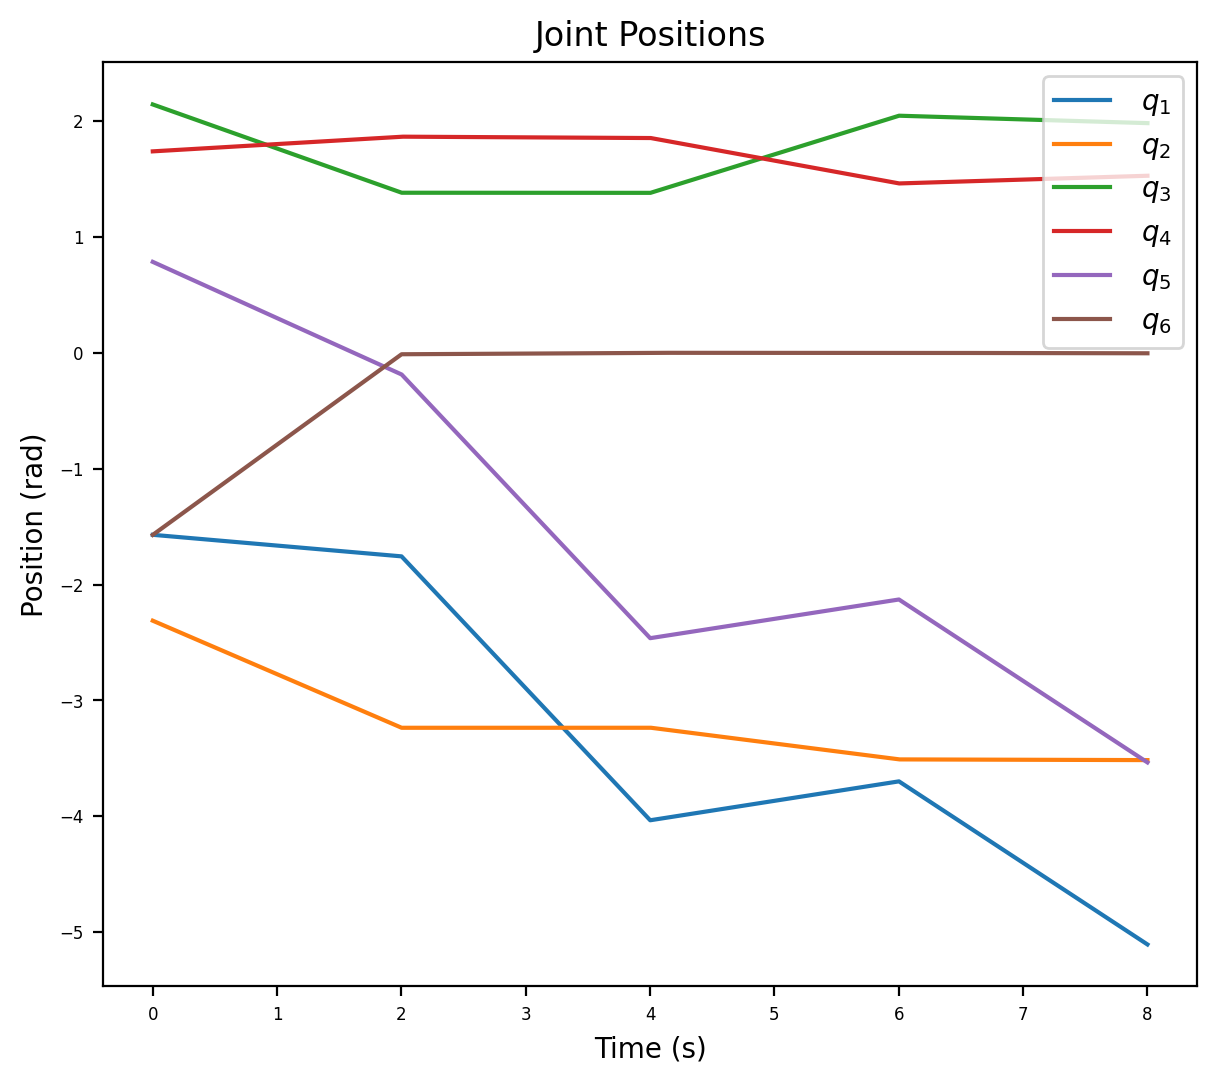

In [72]:
import numpy as np

def linear_trajectory(start_pos, end_pos, num_points):
    t = np.linspace(0, 1, num_points)
    trajectory = np.zeros((num_points, 6))
    
    for i in range(6):
        trajectory[:, i] = np.interp(t, [0, 1], [start_pos[i], end_pos[i]])
    
    return trajectory

# Define all waypoints

# q_grasp = np.array([23.2, -60.39, 106.5, -46.11, 113.2, 0.]) * np.pi/180
# q_liftup = np.array([23.2, -71.38, 43.34, 28.04, 113.2, -0.]) * np.pi/180
# q_place = np.array([-20.24, -49.32, 16.11, 33.21, 69.76, 0.]) * np.pi/180
# waypoints = [q_init, q_grasp, q_liftup, q_place, q_ik]
waypoints = [q_init, q_square_1, q_square_2, q_square_3, q_square_4]

# Define the conditions of the trajectory
duration = 8.0  # Time to complete trajectory for each segment.
num_points = int(duration / env.dt)
trajectories = []

for i in range(len(waypoints)-1):
    start_pos = waypoints[i]
    end_pos = waypoints[i+1]

    trajectory = linear_trajectory(start_pos, end_pos, num_points)
    trajectories.append(trajectory)

# Concatenate all trajectories
trajectory = np.concatenate(trajectories)

# Rest of the code for printing and plotting...
time_step = np.linspace(0, duration, num_points * (len(waypoints)-1))
plt.figure(figsize=(24, 6))
plt.subplot(1, 3, 1)
for i in range(6):
    plt.plot(time_step, trajectory[:, i], label=rf"$\ q_{i+1}$")
plt.xlabel("Time (s)")
plt.ylabel("Position (rad)")
plt.title("Joint Positions")
plt.legend(loc='upper right')
plt.show()


Pressed ESC
Quitting.


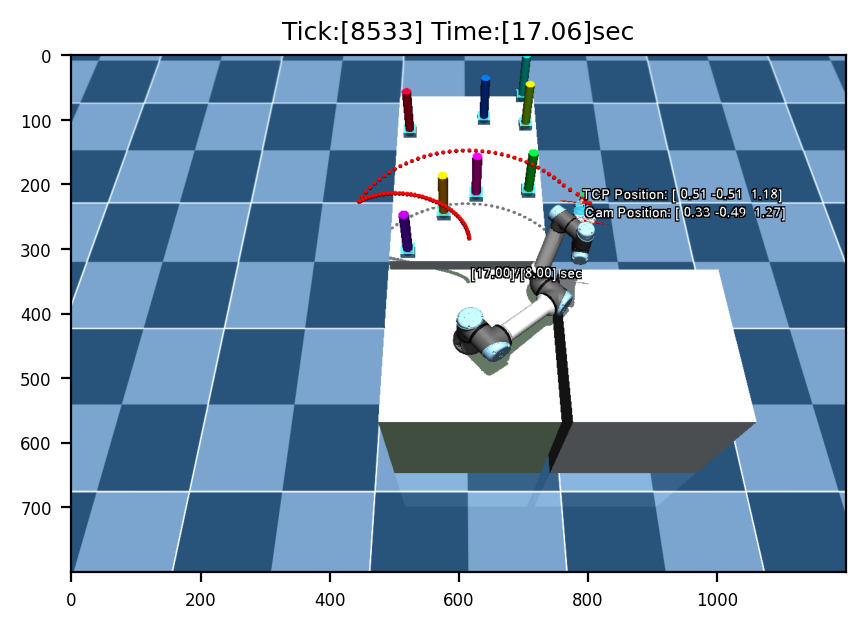

Done.


In [73]:
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=0.0,distance=3.5,elevation=-60,lookat=[0.4,0.05,0.36],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=True,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=True,jointlength=0.5,jointwidth=0.1,jointrgba=[0.2,0.6,0.8,0.6])
env.reset()
env.forward(q=q_init, joint_idxs=env.idxs_forward)

tick_plot = 0
q_traj_list = []

tick = 0
while (env.get_sim_time() < 100.0) and env.is_viewer_alive():
    tick = tick + 1
    if tick >= len(trajectory):
        env.step(ctrl=trajectory[-1,:], ctrl_idxs=env.idxs_forward)
    else:    
        env.step(ctrl=trajectory[tick,:], ctrl_idxs=env.idxs_forward)
        
    # Render
    p_tcp,R_tcp = env.get_pR_body(body_name='tcp_link')

    p_cam,R_cam = env.get_pR_body(body_name='camera_center')
    p_base,R_base = env.get_pR_body(body_name='base')
    # env.plot_T(p=np.zeros(3),R=np.eye(3,3),PLOT_AXIS=True,axis_len=1.0,axis_width=0.01)
    env.plot_T(p=p_tcp,R=R_tcp,PLOT_AXIS=True,axis_len=0.1,axis_width=0.0025,
               label=f'TCP Position: {p_tcp}')
    env.plot_T(p=p_cam,R=R_cam,PLOT_AXIS=True,axis_len=0.1,axis_width=0.0025,
               label=f'Cam Position: {p_cam}')
    # env.plot_T(p=p_base,R=R_base,PLOT_AXIS=True,axis_len=1.0,axis_width=0.01)
    env.plot_T(p=p_base+np.array([0,0,0.5]),R=np.eye(3,3),
                PLOT_AXIS=False,label='[%.2f]/[%.2f] sec'%(env.get_sim_time(), duration))
    q_traj_list.append(p_tcp)
    for p_eef in q_traj_list:
        tick_plot += 1
        if tick_plot % 100 == 0:
            env.plot_sphere(p=p_eef, r=0.01, rgba=[1,0,0,1])
    env.render()
    if env.loop_every(HZ=1) or (tick == 1):
        scene_img = env.grab_image()
# Plot an image
plt.figure(figsize=(5,4)); plt.imshow(scene_img)
plt.title("Tick:[%d] Time:[%.2f]sec"%(env.tick,env.get_sim_time()),fontsize=9)
plt.show()
# Close viewer
env.close_viewer()
print ("Done.")

#### Archive: Trapezoidal velocity profile

2.0
1.0


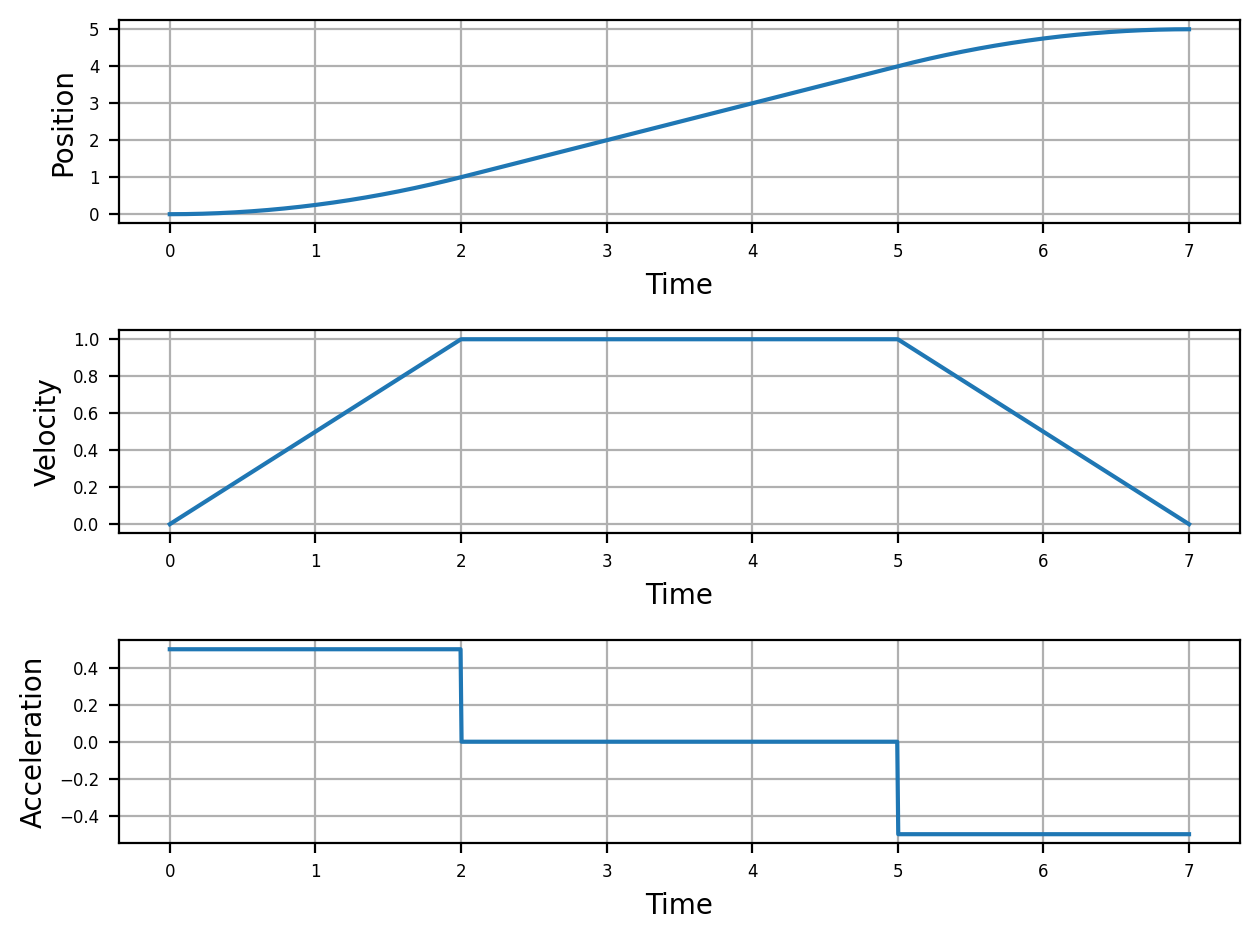

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
v_max = 1.0  # peak velocity
a_max = 0.5  # max acceleration
d_total = 5.0  # total distance

t_ramp = v_max / a_max  # time to accelerate to v_max
print(t_ramp)
d_ramp = 0.5 * a_max * t_ramp ** 2  # distance covered during acceleration (and deceleration)
print(d_ramp)


# Time for constant velocity
if d_total <= 2 * d_ramp:
    # In this case we don't reach the max velocity
    t_ramp = np.sqrt(d_total / a_max)
    t_flat = 0
else:
    t_flat = (d_total - 2 * d_ramp) / v_max

# Total time
t_total = 2 * t_ramp + t_flat

# Time vector
t = np.linspace(0, t_total, 1000)

# Initialize arrays
position = np.zeros_like(t)
velocity = np.zeros_like(t)
acceleration = np.zeros_like(t)

for i in range(len(t)):
    if t[i] < t_ramp:   # Acceleration
        position[i] = 0.5 * a_max * t[i]**2 # eqn. (2.2.1a)
        velocity[i] = a_max * t[i]
        acceleration[i] = a_max
    elif t[i] < (t_ramp + t_flat):  # Constant velocity
        position[i] = v_max * (t[i] - t_ramp / 2)
        velocity[i] = v_max
        acceleration[i] = 0
    else:   # Deceleration
        position[i] = d_total - 0.5 * a_max * (t_total - t[i])**2
        velocity[i] = v_max - a_max * (t[i] - t_ramp - t_flat)
        acceleration[i] = -a_max

# Plot
plt.figure()

plt.subplot(3, 1, 1)
plt.plot(t, position, label='position')
plt.xlabel('Time')
plt.ylabel('Position')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(t, velocity, label='velocity')
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(t, acceleration, label='acceleration')
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.grid(True)

plt.tight_layout()
plt.show()


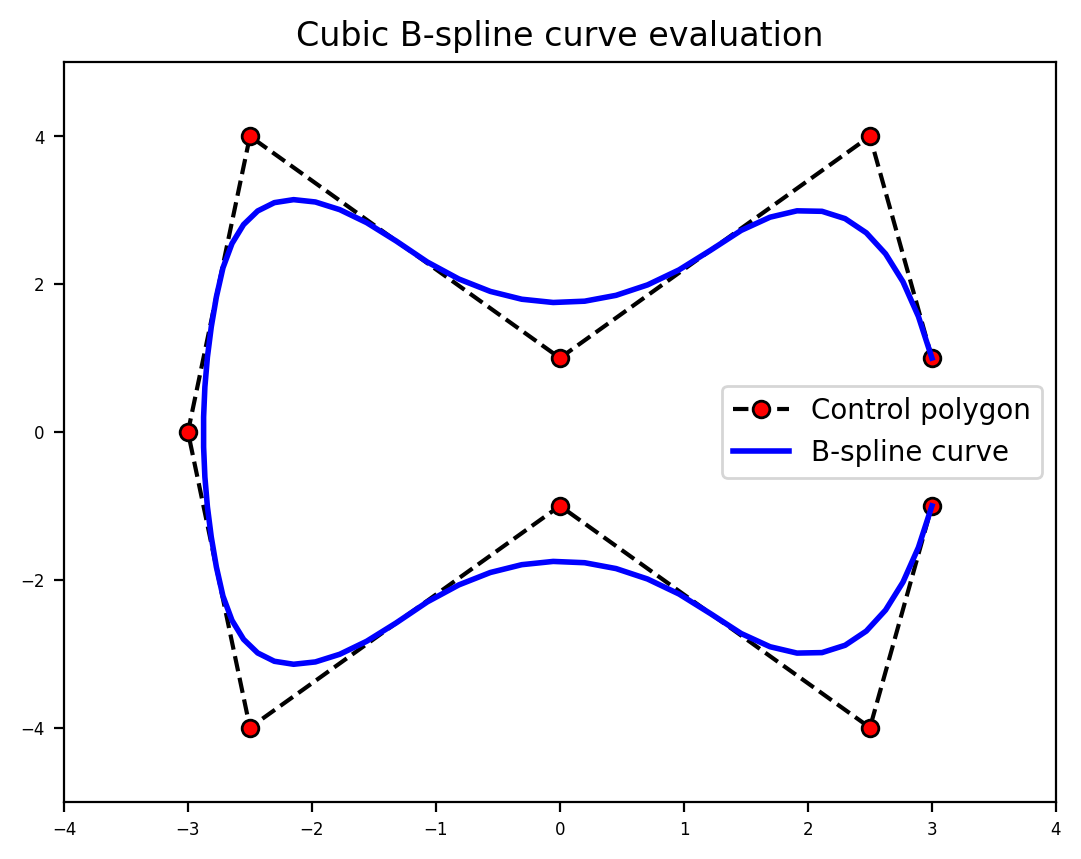

In [64]:
import numpy as np
from scipy import interpolate 
import matplotlib.pyplot as plt
 
plist = [(3 , 1), (2.5, 4), (0, 1),
         (-2.5, 4),(-3, 0), (-2.5, -4),
          (0, -1), (2.5, -4), (3, -1),]
ctr =np.array(plist)
 
x=ctr[:,0]
y=ctr[:,1]
 
l=len(x)
 
Order = 2
 
t=np.linspace(0,1,l-(Order-1),endpoint=True)
t=np.append(np.zeros(Order),t)
t=np.append(t,np.zeros(Order)+1)
 
tck=[t,[x,y],Order]
u3=np.linspace(0,1,(max(l*2,70)),endpoint=True)
out = interpolate.splev(u3,tck)
 
plt.plot(x,y,'k--',label='Control polygon',marker='o',markerfacecolor='red')
plt.plot(out[0],out[1],'b',linewidth=2.0,label='B-spline curve')
plt.legend(loc='best')
plt.axis([min(x)-1, max(x)+1, min(y)-1, max(y)+1])
plt.title('Cubic B-spline curve evaluation')
plt.show()


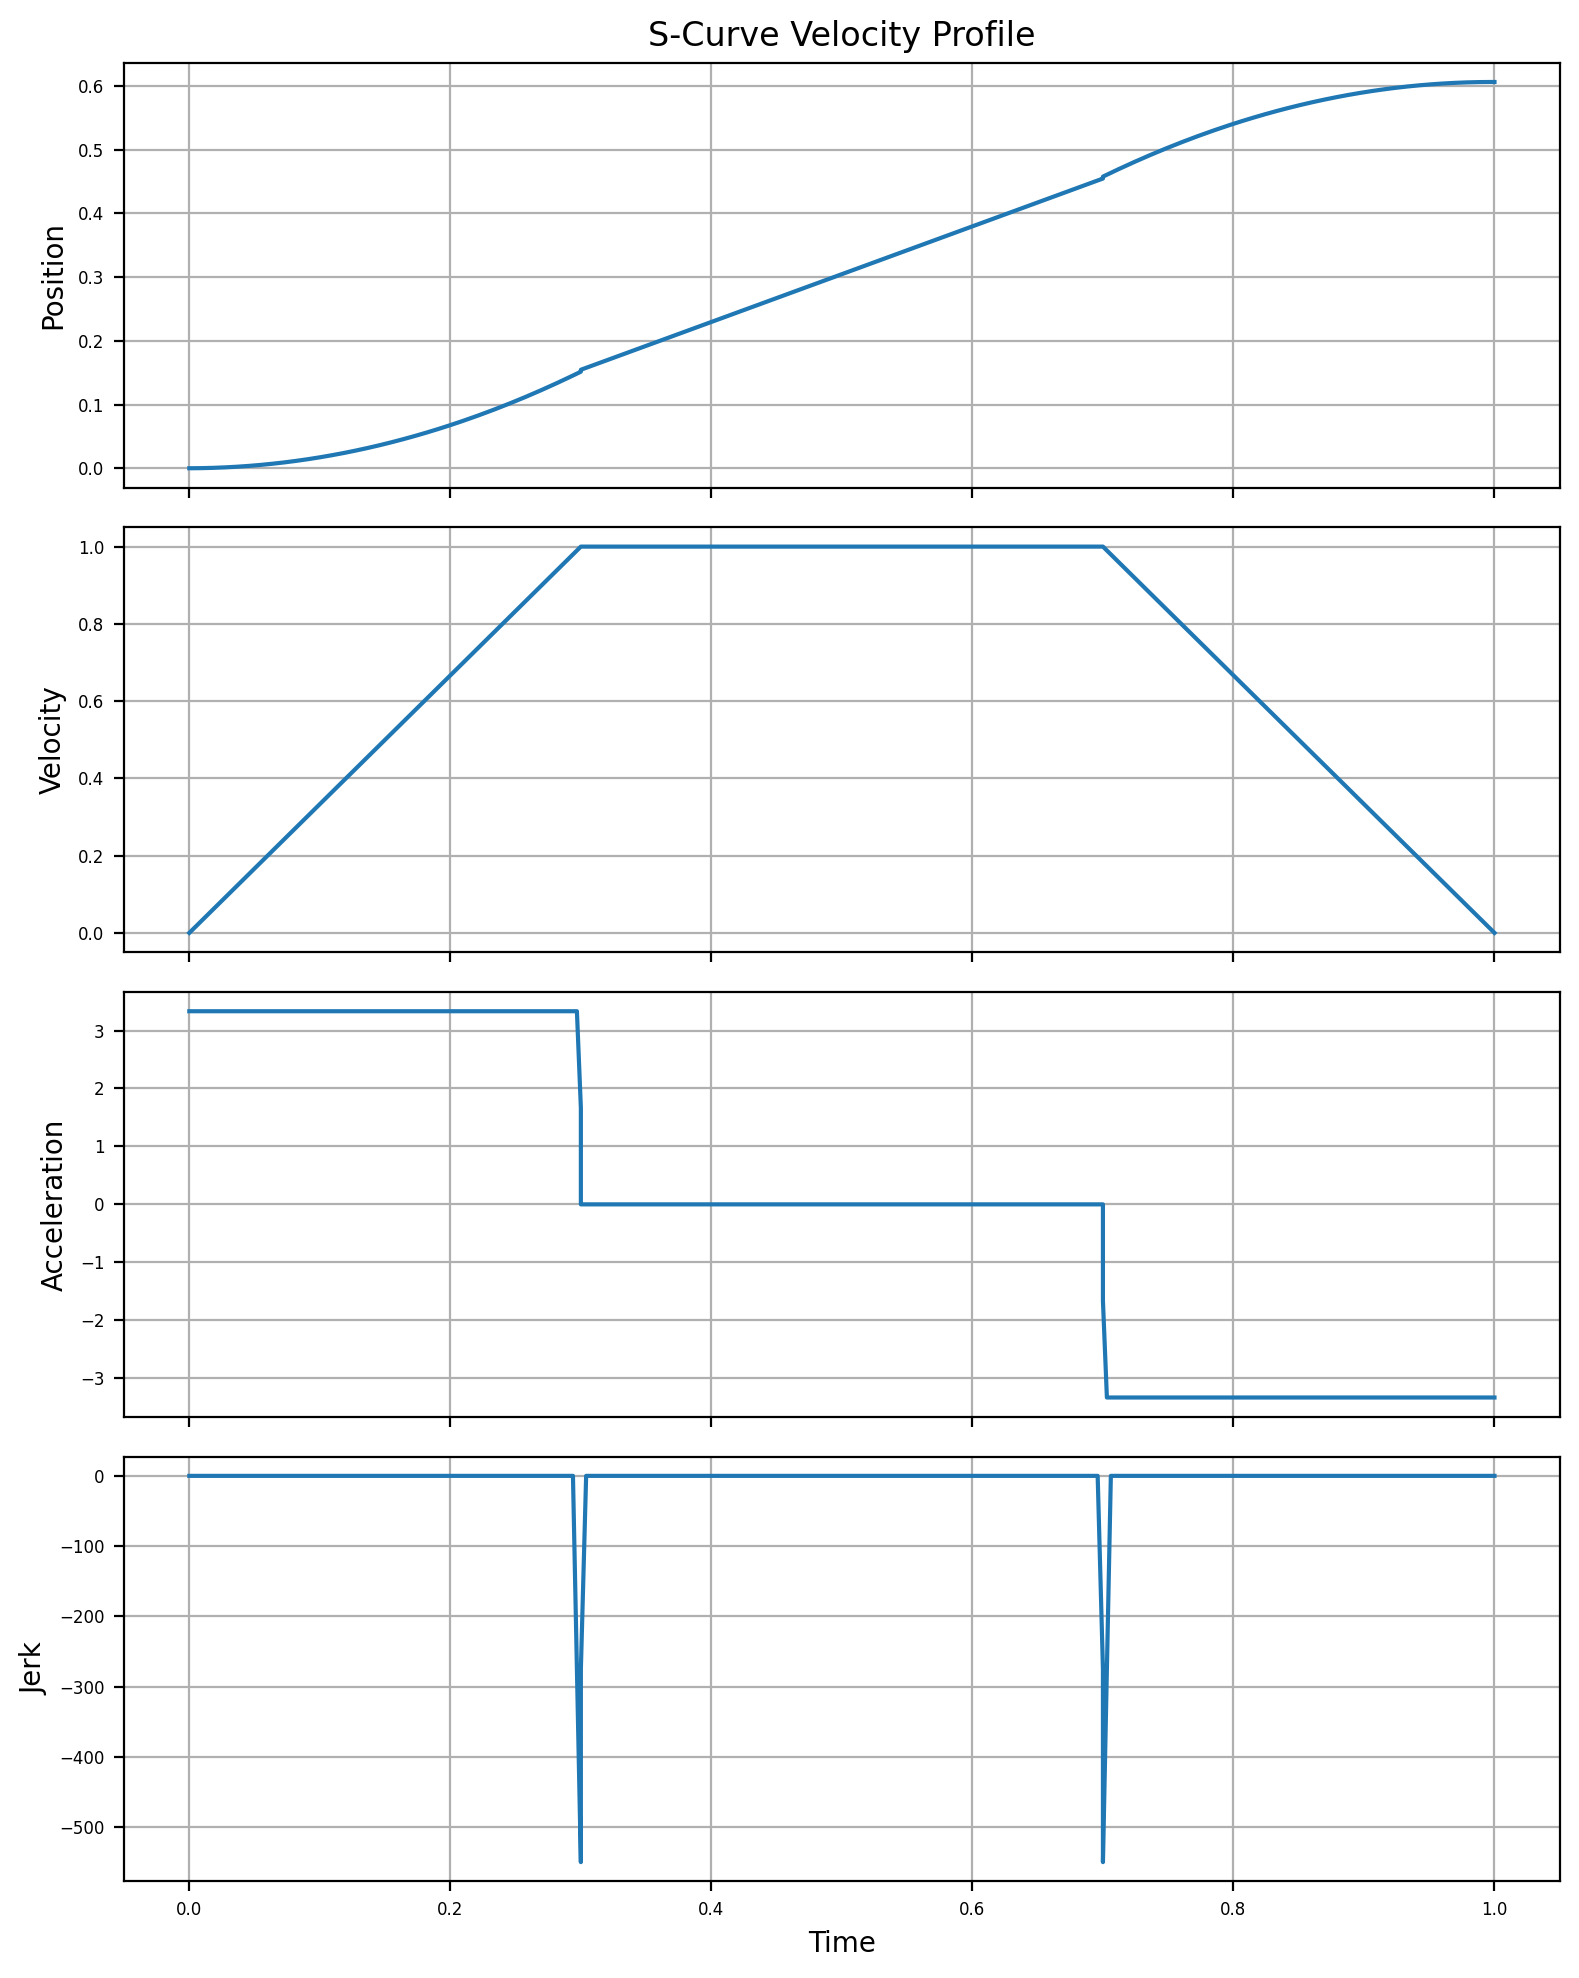

In [111]:
import numpy as np
import matplotlib.pyplot as plt

# Define the S-curve velocity profile
t_total = 1.0  # Total time
t_ramp = 0.3   # Time for acceleration and deceleration ramps

# Define the time intervals
t1 = np.linspace(0, t_ramp, num=100)              # Acceleration ramp
t2 = np.linspace(t_ramp, t_total - t_ramp, num=100)  # Constant velocity
t3 = np.linspace(t_total - t_ramp, t_total, num=100)  # Deceleration ramp

# Define the velocity profile for each interval
v_max = 1.0   # Maximum velocity
a_max = v_max / t_ramp   # Maximum acceleration/deceleration

v1 = a_max * t1    # Acceleration ramp
v2 = np.ones_like(t2) * v_max   # Constant velocity
v3 = v_max - a_max * (t3 - (t_total - t_ramp))  # Deceleration ramp

# Concatenate the time and velocity arrays
t = np.concatenate((t1, t2, t3))
v = np.concatenate((v1, v2, v3))

# Calculate position (p), acceleration (a), and jerk (j) based on velocity (v)
p = np.cumsum(v) * (t[1] - t[0])  # Integration of velocity to get position
a = np.gradient(v, t[1] - t[0])  # Differentiation of velocity to get acceleration
j = np.gradient(a, t[1] - t[0])  # Differentiation of acceleration to get jerk

# Plot the S-curve velocity profile
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(8, 10))
ax1.plot(t, p)
ax1.set_ylabel('Position')
ax1.set_title('S-Curve Velocity Profile')
ax1.grid(True)

ax2.plot(t, v)
ax2.set_ylabel('Velocity')
ax2.grid(True)

ax3.plot(t, a)
ax3.set_ylabel('Acceleration')
ax3.grid(True)

ax4.plot(t, j)
ax4.set_ylabel('Jerk')
ax4.set_xlabel('Time')
ax4.grid(True)

plt.tight_layout()
plt.show()
